## visualize words similarities via t-sne and sentence-transformer 

In [2]:
from sentence_transformers import SentenceTransformer

I1229 16:35:13.771857 139849172682560 file_utils.py:40] PyTorch version 1.1.0 available.


## load pretrained model

In [3]:
model = SentenceTransformer('bert-base-nli-mean-tokens')


I1229 16:35:52.983521 139849172682560 SentenceTransformer.py:29] Load pretrained SentenceTransformer: bert-base-nli-mean-tokens
I1229 16:35:52.985561 139849172682560 SentenceTransformer.py:32] Did not find a / or \ in the name. Assume to download model from server
I1229 16:35:53.160154 139849172682560 SentenceTransformer.py:68] Load SentenceTransformer from folder: /home/saul/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-mean-tokens.zip
I1229 16:35:53.216943 139849172682560 configuration_utils.py:154] loading configuration file /home/saul/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-mean-tokens.zip/0_BERT/config.json
I1229 16:35:53.218326 139849172682560 configuration_utils.py:174] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,

In [5]:
import pandas as pd
from sklearn.manifold import TSNE
import re
from nltk.corpus import stopwords
import numpy as np


In [6]:
#parameters
MIN = 5
STOPWORDS = True
SIZE = 10000


In [7]:
df = pd.read_csv('../data/reddit_batch1/batch.csv')

In [8]:
df = df.iloc[0:SIZE]

In [9]:
nn = df['topic'].unique().shape[0]

In [10]:
stop_words = set(stopwords.words('english'))


In [11]:
#for transformer
def clean_sen_trans(sent):
    clean_list = ''
    if STOPWORDS == True:
        for word in sent.split():
           # print(word)
            if word not in stop_words:
                word = re.sub('[\W_]+','',word)
                word = re.sub(' +', ' ', word)
                clean_list +=word.lower()+str(' ')
    else:
        for word in sent.split():
            word = re.sub('[\W_]+','',word)
            word = re.sub(' +', ' ', word)
            clean_list +=word.lower()+str(' ')

    return clean_list
    

In [12]:
pre1= []
for i in df.sentence:
    clean = clean_sen_trans(i)
    if len(clean) > MIN:
        pre1.append(clean)
       
    
    

In [13]:
embeddings = model.encode(pre1,show_progress_bar=False)

In [14]:
embeddings[0].shape

(768,)

In [15]:
def create_vocab(sens):
    voc = []
    for sen in sens:
        for word in sen.split():
            if not word in voc:
                voc.append(word)
    return voc

In [16]:
voc = create_vocab(pre1)


In [17]:
queries=[]
for i in range(nn):
    queries.append(voc[np.random.randint(0,len(voc))])
print(queries)
query_embeddings = model.encode(queries,show_progress_bar=False)

['walnut', 'select', 'australia', 'obsessions', 'lsd25', 'stop', 'pollack', 'friends']


In [18]:
w_embs = model.encode(voc,show_progress_bar=False)
    

In [19]:
import scipy.spatial
# Find the closest nn words of the corpus for each query sentence based on cosine similarity
closest_n = 15
words_cl=[]
embs_cl=[]
for query, query_embedding in zip(queries, query_embeddings):
  #  distances = scipy.spatial.distance.cdist([query_embedding], embeddings, "cosine")[0]
    distances = scipy.spatial.distance.cdist([query_embedding], w_embs, "cosine")[0]
    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])
    pre_w_cl = []
    pre_e_cl =[]
    for idx, distance in results[0:closest_n]:
        pre_w_cl.append(voc[idx])
        pre_e_cl.append(w_embs[idx])
       
     #   print(pre1[idx].strip(), 1-distance)
        #print(voc[idx].strip(), 1-distance)
    words_cl.append(pre_w_cl)
    embs_cl.append(pre_e_cl)

In [20]:
top = closest_n

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

def plotsne(words,embs,perp):
    
    embs1 = np.array(embs).reshape(nn*top,768) ### reshape to nrandom*topn,DIM
    tsne_2d = TSNE(perplexity=perp, n_components=2, init='pca', n_iter=3500, random_state=32)
    emb_2d = np.array(tsne_2d.fit_transform(np.array(embs1)))    
    
    plt.figure(figsize=(16, 9))
    space = np.expand_dims(np.linspace(0,1,nn),axis=1)
    colors = cm.rainbow(space)
    
    
    j = 0
    jj = 0
    for clust in words:
        
        for i in clust:

            plt.annotate(i,xy=(emb_2d[j][0],emb_2d[j][1]),size=8,alpha=0.5)
       
            plt.scatter(emb_2d[j,0],emb_2d[j,1],alpha=0.8,c=colors[jj])
            j+=1
        jj += 1
    plt.show()

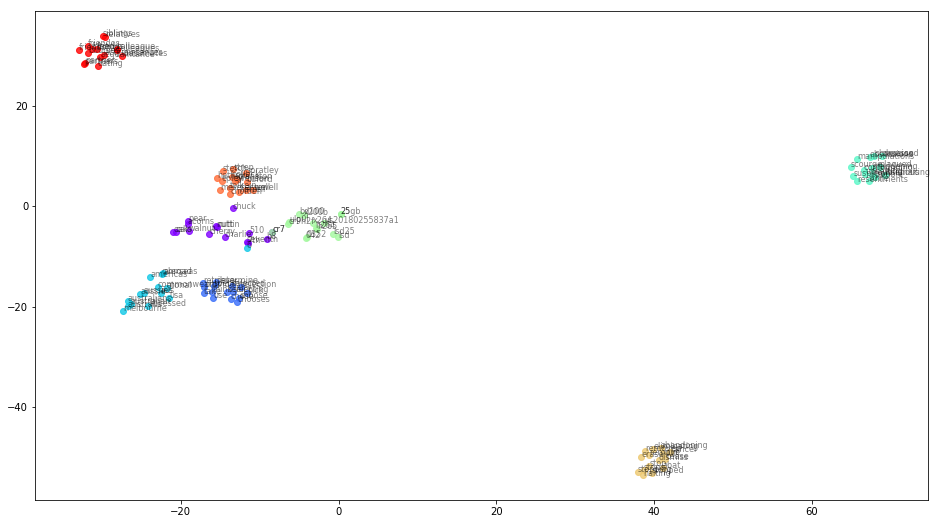

In [22]:
plotsne(words_cl,embs_cl,10)